# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [4]:
import os
import sys
import requests
import pickle
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn.preprocessing

from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool

### библиотеки для работы с S3 
import boto3
import joblib
import json
from io import BytesIO

from dotenv import load_dotenv
load_dotenv()

/Users/andrey/EDU/MLE-USER/.venv_recsys_start/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [5]:
# Сессия для подключения к S3
session = boto3.Session(
    aws_access_key_id=(os.environ["AWS_ACCESS_KEY_ID"]),
    aws_secret_access_key=(os.environ["AWS_SECRET_ACCESS_KEY"]),
)

s3_client = session.client(service_name="s3", endpoint_url=os.environ['S3_ENDPOINT_URL'])

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [8]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

In [9]:
print(f'Tracks: {tracks.shape}')
print(f'Catalog names: {catalog_names.shape}')
print(f'Interactions: {interactions.shape}')

Tracks: (1000000, 4)
Catalog names: (1812471, 3)
Interactions: (222629898, 4)


In [10]:
tracks.head(3)

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]


In [11]:
catalog_names.head(3)

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow


In [12]:
interactions.head(3)

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21


Данные о треках — в файле tracks.parquet:
`track_id` — идентификатор музыкального трека;
`albums` — список идентификаторов альбомов, содержащих трек;
`artists` — список идентификаторов исполнителей трека;
`genres` — список идентификаторов жанров, к которым принадлежит трек.
Имена артистов, названия альбомов, треков и жанров — в файле catalog_names.parquet:
`id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);
`type` — тип идентификатора;
`name` — имя (название) каталожной единицы.
Данные о том, какие пользователи прослушали тот или иной трек, — в файле interactions.parquet :
`user_id` — идентификатор пользователя,
`track_id` — идентификатор музыкального трека,
`track_seq` — номер места трека в истории пользователя,
`started_at` — дата начала прослушивания трека.

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [13]:
# Есть ли пропущенные
def check_missing(df, name):
    print(f"Пропуски в {name}:")
    print(df.isnull().sum())
    print()

check_missing(tracks, 'tracks')
check_missing(catalog_names, 'catalog_names')
check_missing(interactions, 'interactions')

Пропуски в tracks:
track_id    0
albums      0
artists     0
genres      0
dtype: int64

Пропуски в catalog_names:
id      0
type    0
name    0
dtype: int64

Пропуски в interactions:
user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64



In [7]:
# Проверка треков в interactions, которых нет в tracks
missing_tracks = set(interactions['track_id']) - set(tracks['track_id'])
print(f"Треков в interactions, отсутствующих в tracks: {len(missing_tracks)}")

# Проверка альбомов в tracks, которых нет в catalog_names
all_album_ids = set().union(*tracks['albums'].dropna().apply(lambda x: x if isinstance(x, list) else []))
missing_albums = all_album_ids - set(catalog_names[catalog_names['type']=='album']['id'])
print(f"Альбомов в tracks, отсутствующих в catalog_names: {len(missing_albums)}")

# Аналогично для artists и genres
all_artist_ids = set().union(*tracks['artists'].dropna().apply(lambda x: x if isinstance(x, list) else []))
missing_artists = all_artist_ids - set(catalog_names[catalog_names['type']=='artist']['id'])
print(f"Артистов в tracks, отсутствующих в catalog_names: {len(missing_artists)}")

all_genre_ids = set().union(*tracks['genres'].dropna().apply(lambda x: x if isinstance(x, list) else []))
missing_genres = all_genre_ids - set(catalog_names[catalog_names['type']=='genre']['id'])
print(f"Жанров в tracks, отсутствующих в catalog_names: {len(missing_genres)}")

Треков в interactions, отсутствующих в tracks: 0
Альбомов в tracks, отсутствующих в catalog_names: 0
Артистов в tracks, отсутствующих в catalog_names: 0
Жанров в tracks, отсутствующих в catalog_names: 0


In [8]:
# Проверяем аномалии
# Проверка track_seq в interactions
print("Статистика по track_seq:")
print(interactions['track_seq'].describe())

# Проверка на отрицательные значения
negative_seq = interactions[interactions['track_seq'] < 1]
print(f"\nЗаписей с некорректным track_seq: {len(negative_seq)}")

# Проверка user_id
print("\nУникальных пользователей:", interactions['user_id'].nunique())
print("Минимальный user_id:", interactions['user_id'].min())
print("Максимальный user_id:", interactions['user_id'].max())

Статистика по track_seq:
count    2.226299e+08
mean     4.621403e+02
std      8.257312e+02
min      1.000000e+00
25%      5.600000e+01
50%      1.810000e+02
75%      5.060000e+02
max      1.663700e+04
Name: track_seq, dtype: float64

Записей с некорректным track_seq: 0

Уникальных пользователей: 1373221
Минимальный user_id: 0
Максимальный user_id: 1374582


In [12]:
tracks

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]"
999996,101490148,[21403052],[9078726],"[11, 20]"
999997,101493057,[21403883],[11865715],"[44, 75]"
999998,101495927,[21404975],[4462686],"[3, 75]"


In [22]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [25]:
catalog_names.type.unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [14]:
# Подсчет треков с пустыми списками исполнителей
tracks_without_artists = tracks[tracks['artists'].apply(len) == 0]
print(f"Общее количество треков: {len(tracks)}")
print(f"Треков без исполнителей: {len(tracks_without_artists)}")
print(f"Процент треков без исполнителей: {len(tracks_without_artists)/len(tracks)*100:.2f}%")

Общее количество треков: 1000000
Треков без исполнителей: 15369
Процент треков без исполнителей: 1.54%


In [15]:
# Сколько прослушиваний приходится на треки без исполнителей
interactions_with_unknown = interactions[interactions['track_id'].isin(
    tracks_without_artists['track_id'])]
print(f"\nПрослушиваний треков без исполнителей: {len(interactions_with_unknown):,}")
print(f"Доля от общего числа прослушиваний: {len(interactions_with_unknown)/len(interactions)*100:.2f}%")


Прослушиваний треков без исполнителей: 286,442
Доля от общего числа прослушиваний: 0.13%


In [14]:
# 1. Удаляем треки без исполнителей
tracks_clean = tracks[tracks['artists'].apply(len) > 0].copy()

# 2. Удаляем соответствующие взаимодействия
interactions_clean = interactions[interactions['track_id'].isin(tracks_clean['track_id'])].copy()

# 3. Очищаем каталог от удалённых треков
catalog_names_clean = catalog_names[
    ~((catalog_names['type'] == 'track') & 
     (catalog_names['id'].isin(tracks['track_id']) & 
      ~catalog_names['id'].isin(tracks_clean['track_id'])))
].copy()

In [15]:
# Проверяем результаты
print(f"Оригинальное количество треков: {len(tracks):,}")
print(f"Осталось треков: {len(tracks_clean):,} (удалено {len(tracks)-len(tracks_clean):,})")
print(f"Осталось взаимодействий: {len(interactions_clean):,}")
print(f"Осталось записей в каталоге: {len(catalog_names_clean):,}")
print(f"Ссылок на удалённые треки в каталоге: {catalog_names_clean[catalog_names_clean['type'] == 'track']['id'].isin(tracks_to_remove).sum()}")

Оригинальное количество треков: 1,000,000
Осталось треков: 984,631 (удалено 15,369)
Осталось взаимодействий: 222,343,456
Осталось записей в каталоге: 1,797,102


NameError: name 'tracks_to_remove' is not defined

In [17]:
# Добавляем в треки имена (названия, альбомы, имена артистом, названия жанров) из catalog_names

tracks_exploded = tracks_clean.explode('albums').explode('artists').explode('genres')
tracks_exploded

,track_id,albums,artists,genres
0,26,3,16,11
0,26,3,16,21
0,26,2490753,16,11
0,26,2490753,16,21
1,38,3,16,11
...,...,...,...,...
999997,101493057,21403883,11865715,75
999998,101495927,21404975,4462686,3
999998,101495927,21404975,4462686,75
999999,101521819,21414638,5056591,3


In [18]:
tracks_exploded = tracks_exploded.merge(catalog_names[catalog_names["type"] == "album"], how='left', left_on="albums", right_on="id").rename(columns={"name": "album_name"})[["track_id", "albums", "artists", "genres", "album_name"]]
tracks_exploded = tracks_exploded.merge(catalog_names[catalog_names["type"] == "track"], how='left', left_on="track_id", right_on="id").rename(columns={"name": "track_name"})[["track_id", "albums", "artists", "genres", "album_name", "track_name"]]
tracks_exploded = tracks_exploded.merge(catalog_names[catalog_names["type"] == "artist"], how='left', left_on="artists", right_on="id").rename(columns={"name": "artist_name"})[["track_id", "albums", "artists", "genres", "album_name", "track_name", "artist_name"]]
tracks_exploded = tracks_exploded.merge(catalog_names[catalog_names["type"] == "genre"], how='left', left_on="genres", right_on="id").rename(columns={"name": "genre_name"})[["track_id", "albums", "artists", "genres", "album_name", "track_name", "artist_name", "genre_name"]]

tracks_exploded

,track_id,albums,artists,genres,album_name,track_name,artist_name,genre_name
0,26,3,16,11,Taller Children,Complimentary Me,Elizabeth & the Catapult,pop
1,26,3,16,21,Taller Children,Complimentary Me,Elizabeth & the Catapult,folk
2,26,2490753,16,11,Taller Children,Complimentary Me,Elizabeth & the Catapult,pop
3,26,2490753,16,21,Taller Children,Complimentary Me,Elizabeth & the Catapult,folk
4,38,3,16,11,Taller Children,Momma's Boy,Elizabeth & the Catapult,pop
...,...,...,...,...,...,...,...,...
6723517,101493057,21403883,11865715,75,SKITTLES,SKITTLES,WhyBaby?,rap
6723518,101495927,21404975,4462686,3,Москва,Москва,Yanix,rusrap
6723519,101495927,21404975,4462686,75,Москва,Москва,Yanix,rap
6723520,101521819,21414638,5056591,3,Вокзал,Вокзал,Джарахов,rusrap


In [29]:
tracks = tracks_exploded.groupby(["track_id", "track_name"]).agg({"albums": lambda x: list(set(x)), 
                                                                "artists": lambda x: list(set(x)), 
                                                                "genres": lambda x: list(set(x)),
                                                                "album_name": lambda x: list(set(x)),
                                                                "artist_name": lambda x: list(set(x)),
                                                                "genre_name": lambda x: list(set(x))}).reset_index()
tracks = tracks.rename(columns={"albums": "album_ids", 
                                "artists": "artist_ids",
                                "genres": "genre_ids",
                                "album_name": "album_names",
                                "artist_name": "artist_names",
                                "genre_name": "genre_names"})
del tracks_exploded
tracks

,track_id,track_name,album_ids,artist_ids,genre_ids,album_names,artist_names,genre_names
0,26,Complimentary Me,"[2490753, 3]",[16],"[11, 21]",[Taller Children],[Elizabeth & the Catapult],"[folk, pop]"
1,38,Momma's Boy,"[2490753, 3]",[16],"[11, 21]",[Taller Children],[Elizabeth & the Catapult],"[folk, pop]"
2,135,Atticus,"[2490809, 12, 214]",[84],[11],[Wild Young Hearts],[Noisettes],[pop]
3,136,24 Hours,"[2490809, 12, 214]",[84],[11],[Wild Young Hearts],[Noisettes],[pop]
4,138,Don't Upset The Rhythm (Go Baby Go),"[213505, 322, 72292, 6007655, 12, 17294156, 72...",[84],[11],"[Let's Get It Started, 2000s Indie Nostalgia, ...",[Noisettes],[pop]
...,...,...,...,...,...,...,...,...
984626,101478482,На лицо,[21399811],[5540395],"[75, 3]",[На лицо],[FLESH],"[rap, rusrap]"
984627,101490148,Без капли мысли,[21403052],[9078726],"[11, 20]",[Без капли мысли],[Даня Милохин],"[ruspop, pop]"
984628,101493057,SKITTLES,[21403883],[11865715],"[75, 44]",[SKITTLES],[WhyBaby?],"[foreignrap, rap]"
984629,101495927,Москва,[21404975],[4462686],"[75, 3]",[Москва],[Yanix],"[rap, rusrap]"


In [19]:
del tracks_clean

In [20]:
interactions = interactions_clean.copy()

del interactions_clean

Проверим, что атрибут `track_seq` правильно заполнен. Поскольку это номер трека в истории пользователей, то его наибольшее значение для каждого пользователя должно совпадать с общим количеством треков, имеющихся для пользователя.

In [33]:
interactions.groupby('user_id').filter(lambda x: x['track_seq'].max() != len(x))

,user_id,track_id,track_seq,started_at


Пользователей с неправильным максимальным `track_seq`, нет. Значит он заполнен корректно. Вероятно, после EDA его можно использовать для фильтрации пользователей и уменьшения размера датафрейма.

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

1. Серьезных проблем не обнаружено, дубликатов и пустых значений не найдено.
2. Удалил треки без исполнителей, записи в каталоге, взаимодействия , связанные с ними.
3. Добавил в таблицу треков данные из каталога для наглядности.  

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [40]:
track_plays = interactions.groupby("track_id").agg(played_times=("started_at", "count"), unique_users=("user_id", "nunique")).reset_index()
track_plays

,track_id,played_times,unique_users
0,26,5,5
1,38,8,8
2,135,16,16
3,136,7,7
4,138,17,17
...,...,...,...
984626,101478482,6,6
984627,101490148,72,72
984628,101493057,9,9
984629,101495927,20,20


In [41]:
track_plays["played_times"].max()

111062

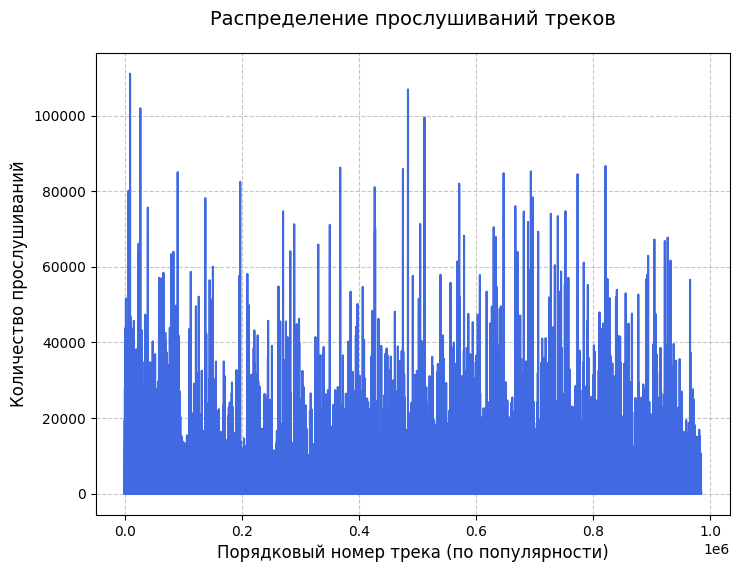

In [43]:
plt.figure(figsize=(18, 6))

ax1 = plt.subplot(121)
ax1.plot(track_plays['played_times'], color='royalblue')
ax1.set_title('Распределение прослушиваний треков', pad=20, fontsize=14)
ax1.set_xlabel('Порядковый номер трека (по популярности)', fontsize=12)
ax1.set_ylabel('Количество прослушиваний', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

Наиболее популярные треки

In [45]:
top100 = track_plays.sort_values(by='played_times', ascending=False).head(100).merge(tracks[["track_id", "track_name", "artist_names", "album_names", "genre_names"]], how='left', left_on="track_id", right_on="track_id")
with pd.option_context('display.max_rows', 100):
    display(top100)

,track_id,played_times,unique_users,track_name,artist_names,album_names,genre_names
0,53404,111062,111062,Smells Like Teen Spirit,[Nirvana],[Smells Like Teen Spirit / In Bloom / On A Pla...,"[allrock, rock, alternative]"
1,33311009,106921,106921,Believer,[Imagine Dragons],"[Throwback Everyday, Pop Hits 2010, Tick Tock ...","[allrock, rock]"
2,178529,101924,101924,Numb,[Linkin Park],"[00s Rock Anthems, Meteora]","[metal, numetal]"
3,35505245,99490,99490,I Got Love,"[Miyagi & Эндшпиль, Рем Дигга]",[I Got Love],"[rap, rusrap]"
4,65851540,86670,86670,Юность,[Dabro],[Юность],"[ruspop, pop]"
5,24692821,86246,86246,Way Down We Go,[KALEO],"[Hits & Stars Winter 2018, Summer Music 2016, ...",[indie]
6,32947997,85886,85886,Shape of You,[Ed Sheeran],"[Shape of You, Pop, Summer Vibes, ÷]",[pop]
7,51241318,85244,85244,In The End,"[Fleurie, Mellen Gi, Tommee Profitt]","[Trending Now 2020: Christian, Summer Road Tri...",[rnb]
8,795836,85042,85042,Shape Of My Heart,[Sting],"[25 Years, The Best Of 25 Years, Сентиментальн...","[allrock, rock, pop]"
9,45499814,84748,84748,Life,[Zivert],"[Vinyl #1. Deluxe Version, Учителя (Музыка из ...","[ruspop, pop]"


Наиболее популярные жанры

In [48]:
top_genres = track_plays.merge(tracks[["track_id", "genre_names"]], how='left', left_on="track_id", right_on="track_id")
top_genres = top_genres.explode("genre_names").rename(columns={"genre_names": "genre"})
top_genres = top_genres.groupby("genre").agg(events=("played_times", "sum")).reset_index().sort_values("events", ascending=False)
top_genres['pct'] = (top_genres['events'] / top_genres['events'].sum()) * 100

# Форматируем вывод для лучшей читаемости
display(top_genres.head(15).style.format({
    'events': '{:,.0f}',
    'pct': '{:.2f}%'
}))


,genre,events,pct
86,pop,"55,578,305",15.09%
92,rap,"37,799,821",10.26%
1,allrock,"31,091,989",8.44%
104,ruspop,"26,626,234",7.23%
105,rusrap,"25,303,695",6.87%
39,electronics,"20,120,694",5.46%
32,dance,"16,291,557",4.42%
106,rusrock,"13,166,147",3.57%
99,rock,"12,772,620",3.47%
75,metal,"12,437,375",3.38%


Треки, которые никто не прослушал

In [51]:
# Находим треки без прослушиваний
unplayed_tracks = tracks[~tracks['track_id'].isin(interactions['track_id'])]

# Выводим статистику
print(f"Всего треков: {len(tracks)}")
print(f"Треков без прослушиваний: {len(unplayed_tracks)} ({len(unplayed_tracks)/len(tracks):.1%})")
print("\nПримеры непрослушанных треков:")
unplayed_tracks.head(10)

Всего треков: 984631
Треков без прослушиваний: 0 (0.0%)

Примеры непрослушанных треков:


,track_id,track_name,album_ids,artist_ids,genre_ids,album_names,artist_names,genre_names


In [52]:
del top_genres

In [54]:
users_plays = interactions.groupby("user_id").agg(events=("track_id", "count"), tracks=("track_id", "nunique")).reset_index()
users_plays

,user_id,events,tracks
0,0,26,26
1,1,36,36
2,2,14,14
3,3,33,33
4,4,255,255
...,...,...,...
1372794,1374578,11,11
1372795,1374579,24,24
1372796,1374580,277,277
1372797,1374581,503,503


In [55]:
users_plays[users_plays["events"] != users_plays["tracks"]]

,user_id,events,tracks


Количество уникальных треков для пользователя совпадает с общим числом взаимодействий пользователя.

In [56]:
print(f"""
10 персентиль: {users_plays['events'].quantile(0.1)} прослушиваний у одного юзера
25 персентиль: {users_plays['events'].quantile(0.25)} прослушиваний у одного юзера
Медиана: {users_plays['events'].quantile(0.5)} прослушиваний у одного юзера
75 персентиль: {users_plays['events'].quantile(0.75)} прослушиваний у одного юзера
90 персентиль: {users_plays['events'].quantile(0.9)} прослушиваний у одного юзера
95 персентиль: {users_plays['events'].quantile(0.95)} прослушиваний у одного юзера
""")


10 персентиль: 14.0 прослушиваний у одного юзера
25 персентиль: 23.0 прослушиваний у одного юзера
Медиана: 55.0 прослушиваний у одного юзера
75 персентиль: 153.0 прослушиваний у одного юзера
90 персентиль: 388.0 прослушиваний у одного юзера
95 персентиль: 650.0 прослушиваний у одного юзера



Этот анализ персентилей показывает сильную неравномерность распределения активности пользователей:

1. Медианный пользователь (50-й персентиль) прослушал всего 55 треков - это означает, что половина пользователей менее активна.
2. Сравнение крайностей:

Наименее активные 10% пользователей (10-й персентиль): ≤14 прослушиваний

Самые активные 5% пользователей (95-й персентиль): ≥650 прослушиваний

Разница в 46 раз между нижними и верхними сегментами!

Для "холодных" пользователей (10-25 персентиль) нужны упрощенные onboarding-механики

Тем не менее не считаю, что стоит удалять таких пользователей из данных, так как они показывают естественное распределение аудитории

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [57]:
# удаляем идентификаторы и переименовываем столбцы
items = tracks.drop(["album_ids", "artist_ids",	"genre_ids"], axis=1).rename(columns={"track_id": "item_id", "track_name": "name"})
del tracks

In [58]:
events = interactions.drop("track_seq", axis=1).rename(columns={"track_id": "item_id"})
del interactions, catalog_names

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [59]:
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

In [62]:
import os

aws_bucket_name = os.environ.get("AWS_BUCKET_NAME")

if aws_bucket_name:
    print(f"Имя S3 бакета: {aws_bucket_name}")
else:
    print("Переменная AWS_BUCKET_NAME не установлена")

Переменная AWS_BUCKET_NAME не установлена


In [68]:
# Сохраняем файлы в S3-бакете
s3_recsys_path = "recsys/data/"
s3_client.upload_file('items.parquet', os.environ.get("AWS_BUCKET_NAME"), f'{s3_recsys_path}items.parquet')
s3_client.upload_file('events.parquet', os.environ.get("AWS_BUCKET_NAME"), f'{s3_recsys_path}events.parquet')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [ ]:
# Следует перезапустить kernel, выполнить импорт библиотек (1 секция) и создать подключение к s3 (2 секция).
# Затем продолжить с этапа 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [3]:
items_s3_object = s3_client.get_object(Bucket=os.environ.get("AWS_BUCKET_NAME"), Key='recsys/data/items.parquet') 
events_s3_object = s3_client.get_object(Bucket=os.environ.get("AWS_BUCKET_NAME"), Key='recsys/data/events.parquet') 

items = pd.read_parquet(BytesIO(items_s3_object['Body'].read()))
events = pd.read_parquet(BytesIO(events_s3_object['Body'].read()))
del items_s3_object, events_s3_object

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [4]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16") #.date()

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = set(list(users_train)).intersection(set(list(users_test)))

print(len(users_train), len(users_test), len(common_users))

1342147 782296 751644


In [5]:
# «Холодные» пользователи — те, которые есть в test, но отсутствуют в train
cold_users = list(set(users_test) - set(users_train))
len(cold_users)

30652

# Топ популярных

Рассчитаем рекомендации как топ популярных.

В топ включим 100 самых прослушиваемых композиций. 
*Поскольку в имеющемся датасете количество уникальных пользователей для трека = общему количеству прослушиванием, будем считать количество прослушиваний как метрику популярности трека.

In [6]:
item_plays = events_train.groupby("item_id").agg(plays=("started_at", "count"))
item_plays = item_plays.merge(items, how="left", on="item_id").sort_values(by="plays", ascending=False)[:100].reset_index(drop=True)
item_plays["rank"] = item_plays["plays"].rank(ascending=False)
item_plays = item_plays.rename(columns={"plays": "score"})
item_plays

,item_id,score,name,album_names,artist_names,genre_names,rank
0,53404,110026,Smells Like Teen Spirit,[Smells Like Teen Spirit / In Bloom / On A Pla...,[Nirvana],"[allrock, rock, alternative]",1.0
1,33311009,101076,Believer,"[Throwback Everyday, Pop Hits 2010, Tick Tock ...",[Imagine Dragons],"[allrock, rock]",2.0
2,178529,100866,Numb,"[00s Rock Anthems, Meteora]",[Linkin Park],"[metal, numetal]",3.0
3,35505245,95523,I Got Love,[I Got Love],"[Miyagi & Эндшпиль, Рем Дигга]","[rap, rusrap]",4.0
4,24692821,84153,Way Down We Go,"[Hits & Stars Winter 2018, Summer Music 2016, ...",[KALEO],[indie],5.0
...,...,...,...,...,...,...,...
95,68562711,47588,Сияй,[Сияй],[Ramil'],"[ruspop, pop]",96.0
96,75944934,47536,Astronaut In The Ocean,"[Astronaut In The Ocean, Astronomical]",[Masked Wolf],"[foreignrap, rap]",97.0
97,75642961,47438,Венера-Юпитер,[Венера-Юпитер],[Ваня Дмитриенко],"[ruspop, pop]",98.0
98,29175370,47320,Рапапам,[Рапапам],"[9 грамм, Miyagi & Эндшпиль]","[rap, rusrap]",99.0


In [8]:
item_plays.to_parquet("top_popular.parquet")

In [10]:
# Сохраняем топ популярных в S3-бакете
s3_recommendations_path = "recsys/recommendations/"
s3_client.upload_file('top_popular.parquet', os.environ.get("AWS_BUCKET_NAME"), f'{s3_recommendations_path}top_popular.parquet')

# Персональные

Рассчитаем персональные рекомендации.

In [18]:
# Перекодируем идентификаторы пользователей: 
# в последовательность от 0 до n-1, где n - количество пользователей
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы треков
# в последовательность от 0 до n-1, где n - количество треков
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

/var/folders/ql/2888r0n15z10l_n3_jkzt7dh0000gn/T/ipykernel_2328/4064307260.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/var/folders/ql/2888r0n15z10l_n3_jkzt7dh0000gn/T/ipykernel_2328/4064307260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
/var/folders/ql/2888r0n15z10l_n3_jkzt7dh0000gn/T/ipykernel_2328/4064307260.py:13: SettingWithCopyWarning

In [19]:
# Формируем колонку target (1 - трек прослушан, 0 - нет)
events_train['target'] = 1

# Создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["target"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

/var/folders/ql/2888r0n15z10l_n3_jkzt7dh0000gn/T/ipykernel_2328/1158543400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train['target'] = 1


In [20]:
# вес матрицы
sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3

4.854126437567174

In [15]:
#сохраним матрицу
scipy.sparse.save_npz('user_item_matrix_train.npz', user_item_matrix_train)

In [16]:
del events, items, events_train, events_test, item_encoder, user_encoder

In [11]:
# загрузка созданной раннее матрицы
# user_item_matrix_train = scipy.sparse.load_npz('user_item_matrix_train.npz')

Имея подготовленную матрицу взаимодействий, перейдём к третьему шагу — создадим ALS-модель. Для примера возьмём количество латентных факторов для матриц $P, Q$, равным 50. 

In [ ]:
als_model = AlternatingLeastSquares(factors=25, iterations=25, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

In [ ]:
# сохраним модель

os.makedirs('models', exist_ok=True)
with open('models/als_model.pkl', 'wb') as file:
    joblib.dump(als_model, file)

In [6]:
# загрузка модели

with open('models/als_model.pkl', 'rb') as file:
    als_model = joblib.load(file)

In [16]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
        user_id_enc, 
        user_item_matrix[user_id_enc], 
        filter_already_liked_items=not include_seen,
        N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [13]:
user_id = events_train['user_id'].sample().iat[0]
print(f"user_id: {user_id}")

print("История (последние события)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("item_id")[["name", "artist_names", "genre_names", "album_names"]], on="item_id")
)

user_history_to_print = user_history[["item_id", "name", "started_at", "artist_names", "genre_names", "album_names"]].tail(10)
display(user_history_to_print)

user_id: 171965
История (последние события)


,item_id,name,started_at,artist_names,genre_names,album_names
375,76670237,туДЫМ-сюДЫМ,2022-11-19,"[Артур Пирожков, DJ Nejtrino]",[pop],[туДЫМ-сюДЫМ]
376,77380649,После пяти,2022-11-19,[Звонкий],"[ruspop, pop]",[После пяти]
377,80582763,Ocean,2022-11-19,"[Kállay Saunders, Ali Bakgor]",[dance],"[Best Radio Tracks, Vol. 22, Ocean]"
378,81779956,WITHOUT YOU,2022-11-20,"[The Kid LAROI, Miley Cyrus]",[pop],[WITHOUT YOU]
379,85227904,Moving On,2022-11-20,[Dennis Lloyd],[pop],[Some Days]
380,85227911,Irrelevant,2022-11-22,[Dennis Lloyd],[pop],[Some Days]
381,85227915,Some Days,2022-11-22,[Dennis Lloyd],[pop],[Some Days]
382,88474192,Я в моменте 2,2022-11-22,"[Mary Gu, Джарахов]","[ruspop, pop]",[Я в моменте 2]
383,88987175,"Как дела, малыш?",2022-11-22,"[Мари Краймбрери, Звонкий]","[ruspop, pop]","[Как дела, малыш?]"
384,90663907,А Я Е,2022-11-23,[Subbota],"[allrock, rock]",[А Я Е]


In [14]:
user_id = events_train['user_id'].sample().iat[0]
print(f"user_id: {user_id}")

print("История (последние события)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("item_id")[["name", "artist_names", "genre_names", "album_names"]], on="item_id")
)

user_history_to_print = user_history[["item_id", "name", "started_at", "artist_names", "genre_names", "album_names"]].tail(10)
display(user_history_to_print)

user_id: 1364697
История (последние события)


,item_id,name,started_at,artist_names,genre_names,album_names
134,92265907,Поезд на Ленинград,2022-09-26,"[Andi Vax, Vadim Shantor]",[dance],[Поезд на Ленинград]
135,92690067,All Over Again,2022-09-28,[MALFA],[dance],[All Over Again]
136,93840817,The Spell,2022-10-03,[TRITICUM],[dance],"[GANGSTER MUSIC, Vol. 5, The Spell]"
137,93920151,The Road to Mandalay,2022-10-05,[DJ JEDY],[dance],"[The Road to Mandalay, EFFECTIVE STARS, Vol. 4]"
138,94697345,It Don’t Matter,2022-10-08,"[Sofi Tukker, Alok, INNA]",[dance],"[Annual 2021, It Don’t Matter]"
139,94800875,I'll Never Be Lonely,2022-10-10,[TRITICUM],[dance],"[EFFECTIVE STARS, Vol. 4, I'll Never Be Lonely]"
140,96694007,ЛЮБИ,2022-10-15,"[DNDM, Sugdiyona Abdulhayevna]",[pop],[ЛЮБИ]
141,97161375,Mr. Sandman,2022-10-17,[Nito-Onna],[electronics],[Mr. Sandman]
142,98810911,Mənim,2022-10-19,[Roudeep],"[electronics, techno]",[Mənim]
143,100395939,Opening my wings at the top of the world,2022-10-21,[George Kopaliani],[electronics],[Opening my wings at the top of the world]


In [21]:
print("Рекомендации (c увиденными)")
user_recommendations = get_recommendations_als(
                                            user_item_matrix_train,
                                            als_model,
                                            user_id,
                                            user_encoder,
                                            item_encoder,
                                            include_seen=True
                                            )
user_recommendations = user_recommendations.merge(items[["item_id", "name", "artist_names", "genre_names", "album_names"]], on="item_id")
display(user_recommendations)

print("Рекомендации (без увиденных)")
user_recommendations = get_recommendations_als(
                                            user_item_matrix_train,
                                            als_model,
                                            user_id,
                                            user_encoder,
                                            item_encoder,
                                            include_seen=False
                                            )
user_recommendations = user_recommendations.merge(items[["item_id", "name", "artist_names", "genre_names", "album_names"]], on="item_id")
display(user_recommendations)

Рекомендации (c увиденными)


,item_id_enc,score,item_id,name,artist_names,genre_names,album_names
0,904666,0.103843,78426489,Rampampam,[Minelli],[dance],[Rampampam]
1,693762,0.085748,51241318,In The End,"[Fleurie, Mellen Gi, Tommee Profitt]",[rnb],"[Trending Now 2020: Christian, Summer Road Tri..."
2,711363,0.076000,52946333,Friendships,[Pascal Letoublon],[dance],"[Deep House Chill, Vol. 03, Best of LW House I..."
3,927425,0.075916,83063895,Птичка,[HammAli & Navai],"[ruspop, pop]",[Птичка]
4,706308,0.075707,52395280,Paris,[Else],[electronics],[Paris]


Рекомендации (без увиденных)


,item_id_enc,score,item_id,name,artist_names,genre_names,album_names
0,904666,0.103843,78426489,Rampampam,[Minelli],[dance],[Rampampam]
1,693762,0.085748,51241318,In The End,"[Fleurie, Mellen Gi, Tommee Profitt]",[rnb],"[Trending Now 2020: Christian, Summer Road Tri..."
2,711363,0.076000,52946333,Friendships,[Pascal Letoublon],[dance],"[Deep House Chill, Vol. 03, Best of LW House I..."
3,927425,0.075916,83063895,Птичка,[HammAli & Navai],"[ruspop, pop]",[Птичка]
4,706308,0.075707,52395280,Paris,[Else],[electronics],[Paris]


In [ ]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получим 30 рекомендаций для каждого пользователя
als_recommendations = als_model.recommend(
                                        user_ids_encoded, 
                                        user_item_matrix_train[user_ids_encoded], 
                                        filter_already_liked_items=False, 
                                        N=30
                                        )

In [ ]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [ ]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("personal_als.parquet")  

In [ ]:
s3_recommendations_path = "recsys/recommendations/"
s3_client.upload_file('personal_als.parquet', os.environ.get("AWS_BUCKET_NAME"), f'{s3_recommendations_path}personal_als.parquet')

In [8]:
als_recommendations = pd.read_parquet('personal_als.parquet')

In [10]:
als_recommendations

,user_id,item_id,score
0,0,29213451,0.008528
1,0,33308946,0.008320
2,0,597196,0.007392
3,0,9047114,0.007236
4,0,582507,0.007201
...,...,...,...
41183965,1374582,62208587,0.115840
41183966,1374582,67854450,0.115839
41183967,1374582,70421915,0.115822
41183968,1374582,41631554,0.115044


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [23]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['item_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score":  sim_item_scores.tolist()
        })
similar_items = similar_items.explode(["sim_item_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items['item_id_enc'])
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items['sim_item_id_enc'])
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

In [24]:
similar_items.to_parquet("similar.parquet")

In [34]:
s3_recommendations_path = "recsys/recommendations/"
s3_client.upload_file('similar.parquet', os.environ.get("AWS_BUCKET_NAME"), f'{s3_recommendations_path}similar.parquet')

проведем проверку схожести треков

In [27]:
def print_sim_items(item_id, similar_items):

    item_columns_to_use = ["item_id", "name", "album_names", "artist_names", "genre_names"]
    
    item_id_1 = items.query("item_id == @item_id")[item_columns_to_use]
    display(item_id_1)
    
    si = similar_items.query("item_id_1 == @item_id")
    si = si.merge(items[item_columns_to_use].set_index("item_id"), left_on="item_id_2", right_index=True)
    display(si)

In [32]:
items[items['name'] == 'Orion']

,item_id,name,album_names,artist_names,genre_names,item_id_enc
3554,20141,Orion,[Master Of Puppets],[Metallica],"[None, metal]",3554
48896,435318,Orion,[Stormwatch],[Jethro Tull],"[folkrock, allrock]",48896
94436,823781,Orion,[Fantasia d'Estate - Fantasien zur Sommerzeit ...,[Rondò Veneziano],[relax],94436
154747,3876078,Orion,[Songs in the Key of D],[Sithu Aye],[metal],154747
215486,9715996,Orion,[Silence The World],[Adept],"[posthardcore, alternative]",215486
295535,18982803,Orion,[Live In Japan],[Rodrigo y Gabriela],"[latinfolk, folk]",295535
305157,19750511,Orion,[Outside the Universe],[Widek],"[progmetal, metal]",305157
344534,23129101,Orion,[Танцевальный рай: Trance Collection],[Dirty Ducks],"[electronics, trance]",344534
382536,25775760,Orion,"[Ninety9Lives: Best of 2015, Orion, Ninety9Liv...","[Starlyte, Jim Yosef]",[electronics],382536
384439,25887149,Orion,[Reflections],[Jennifer Ann],"[classicalmusic, modern]",384439


In [33]:
print_sim_items(20141, similar_items) # треки, похожие на "Orion"

,item_id,name,album_names,artist_names,genre_names
3554,20141,Orion,[Master Of Puppets],[Metallica],"[None, metal]"


,score,item_id_1,item_id_2,name,album_names,artist_names,genre_names
2156837,0.987361,20141,20149,Welcome Home (Sanitarium),[Master Of Puppets],[Metallica],"[None, metal]"
2156838,0.985534,20141,20139,Battery,[Master Of Puppets],[Metallica],"[None, metal]"
2156839,0.983609,20141,20143,Master Of Puppets,[Master Of Puppets],[Metallica],"[None, metal]"
2156840,0.975165,20141,28135325,Fade to Black,"[Woodstock, Saugerties, New York, August 13th,...",[Metallica],"[None, metal]"
2156841,0.974096,20141,28135322,Master of Puppets,"[Woodstock, Saugerties, New York, August 13th,...",[Metallica],"[None, metal]"
2156842,0.970682,20141,16378441,For Whom the Bell Tolls,[The 25th Anniversary Rock and Roll Hall of Fa...,[Metallica],"[allrock, rock]"
2156843,0.961621,20141,20153,The Thing That Should Not Be,[Master Of Puppets],[Metallica],"[None, metal]"
2156844,0.960932,20141,31547878,Battery,[Winnipeg 1986],[Metallica],"[None, metal]"
2156845,0.959108,20141,31547879,Masters of Puppets,[Winnipeg 1986],[Metallica],"[None, metal]"
2156846,0.954225,20141,20151,Leper Messiah,[Master Of Puppets],[Metallica],"[None, metal]"


Насколько могу судить, рекомендации работают неплохо. 

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

В качестве признаков возьмём оценку ALS-модели, количество прослушанных треков пользователем, а также "предпочтение" пользователя по различным жанрам.

На этом этапе необходимо перезагрузить kernel и выполнить две первые ячейки ноутбука

Загружаем данные и кандидатов - персональные рекомендации

In [35]:
als_recommendations_s3_object = s3_client.get_object(Bucket=os.environ.get("AWS_BUCKET_NAME"), Key='recsys/recommendations/personal_als.parquet') 
items_s3_object = s3_client.get_object(Bucket=os.environ.get("AWS_BUCKET_NAME"), Key='recsys/data/items.parquet') 
events_s3_object = s3_client.get_object(Bucket=os.environ.get("AWS_BUCKET_NAME"), Key='recsys/data/events.parquet') 

items = pd.read_parquet(BytesIO(items_s3_object['Body'].read()))
events = pd.read_parquet(BytesIO(events_s3_object['Body'].read()))
candidates = pd.read_parquet(BytesIO(als_recommendations_s3_object['Body'].read()))

del als_recommendations_s3_object, events_s3_object, items_s3_object

In [36]:
candidates

,user_id,item_id,score
0,0,29213451,0.008528
1,0,33308946,0.008320
2,0,597196,0.007392
3,0,9047114,0.007236
4,0,582507,0.007201
...,...,...,...
41183965,1374582,62208587,0.115840
41183966,1374582,67854450,0.115839
41183967,1374582,70421915,0.115822
41183968,1374582,41631554,0.115044


In [37]:
# вновь выполним разбиение (после перезагрузки ядра)

train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

del events

In [38]:
candidates_for_train = candidates.rename(columns={'score': 'als_score'})
del candidates
events_test["target"] = 1
candidates_for_train = candidates_for_train.merge(events_test[["user_id", "item_id", "target"]], 
                            on=["user_id", "item_id"], 
                            how='left') 

candidates_for_train["target"] = candidates_for_train["target"].fillna(0).astype("int")

Добавим кандидатам пользовательский признак - количество прослушанных треков:


In [39]:
def get_user_features(events):
    
    user_features = events.groupby("user_id").agg(
        tracks_played =("started_at", "count")
    )

    return user_features
    

user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")

Добавим признаки, говорящие о том, какие жанры предпочитает пользователь

In [40]:
# составим список жанров и оценкой популярности каждого из них
genres_exploded = items.explode('genre_names')
genres_exploded = pd.DataFrame(genres_exploded.groupby('genre_names').agg(items_count=('name', 'count'))).reset_index().rename(columns={'genre_names': 'genre_name'})
genres_exploded['score'] = genres_exploded['items_count'] / genres_exploded['items_count'].sum()
genres = genres_exploded.sort_values(by='score', ascending=False).reset_index(drop=True).reset_index(names=['genre_id'])
del genres_exploded
genres = genres.rename(columns={"genre_name": "name"})
genres.head()

,genre_id,name,items_count,score
0,0,pop,166284,0.106413
1,1,rap,128212,0.082049
2,2,allrock,118506,0.075837
3,3,electronics,114232,0.073102
4,4,metal,72311,0.046275


Сделаем рязряженную матрицу треки-жанры:

In [41]:
def get_item2genre_matrix(genres, items):

    genre_names_to_id = genres.reset_index().set_index("name")["genre_id"].to_dict()
    
    # list to build CSR matrix
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []
    
    for item_idx, (k, v) in enumerate(items.iterrows()):   

        item_genres = list(v["genre_names"])
        
        for genre_name in item_genres:
            if genre_name is None:
                continue
            
            genre_idx = genre_names_to_id[genre_name]
            genres_csr_data.append(1)
            genres_csr_row_idx.append(item_idx)
            genres_csr_col_idx.append(genre_idx)

    genres_csr = scipy.sparse.csr_matrix((genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)), \
                                        shape=(len(items), len(genres)))
    
    # нормализуем, чтобы сумма оценок принадлежности к жанрам была равна 1
    genres_csr = sklearn.preprocessing.normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr

In [42]:
all_items_genres_csr = get_item2genre_matrix(genres, items)

In [43]:
# сохранение csr-матрицы
scipy.sparse.save_npz('all_items_genres_csr.npz', all_items_genres_csr)

In [ ]:
# загрузка csr-матрицы
all_items_genres_csr = scipy.sparse.load_npz('all_items_genres_csr.npz')

In [44]:
print(all_items_genres_csr)

  (0, 0)	0.5
  (0, 13)	0.5
  (1, 0)	0.5
  (1, 13)	0.5
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 2)	0.5
  (9, 28)	0.5
  (10, 0)	1.0
  (11, 2)	0.5
  (11, 28)	0.5
  (12, 2)	0.5
  (12, 28)	0.5
  (13, 2)	0.5
  (13, 28)	0.5
  (14, 2)	0.5
  (14, 28)	0.5
  (15, 2)	0.5
  (15, 28)	0.5
  (16, 2)	0.5
  :	:
  (984613, 0)	1.0
  (984614, 0)	1.0
  (984615, 0)	1.0
  (984616, 0)	1.0
  (984617, 0)	1.0
  (984618, 0)	1.0
  (984619, 0)	1.0
  (984620, 0)	1.0
  (984621, 0)	1.0
  (984622, 13)	1.0
  (984623, 0)	0.5
  (984623, 9)	0.5
  (984624, 10)	1.0
  (984625, 0)	0.5
  (984625, 9)	0.5
  (984626, 1)	0.5
  (984626, 5)	0.5
  (984627, 0)	0.5
  (984627, 9)	0.5
  (984628, 1)	0.5
  (984628, 6)	0.5
  (984629, 1)	0.5
  (984629, 5)	0.5
  (984630, 1)	0.5
  (984630, 5)	0.5


In [45]:
# определяем индексы топ-10 жанров и всех остальных
genres_top_k = 10
genres_top_idx = genres.sort_values("items_count", ascending=False).head(genres_top_k).index
genres_others_idx = list(set(genres.index) - set(genres_top_idx))

genres_top_columns = [f"genre_{id}" for id in genres_top_idx]
genres_others_column = "genre_others"
genre_columns = genres_top_columns + [genres_others_column]

In [46]:
# составляем таблицу принадлежности треков к жанрам
item_genres = (
    pd.concat([
        # топ жанров
        pd.DataFrame(all_items_genres_csr[:, genres_top_idx].toarray(), columns=genres_top_columns), 
        # все остальные жанры
        pd.DataFrame(all_items_genres_csr[:, genres_others_idx].sum(axis=1), columns=[genres_others_column])
        ],
        axis=1)
    .reset_index()
    .rename(columns={"index": "item_id_enc"})
)

In [47]:
item_genres

,item_id_enc,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_others
0,0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
984626,984626,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
984627,984627,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
984628,984628,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
984629,984629,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [48]:
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])

In [49]:
# объединяем информацию принадлежности треков к жанрам с основной информацией о треках
items = items.merge(item_genres, on="item_id_enc", how="left")
items.head()

,item_id,name,album_names,artist_names,genre_names,item_id_enc,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_others
0,26,Complimentary Me,[Taller Children],[Elizabeth & the Catapult],"[folk, pop]",0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,38,Momma's Boy,[Taller Children],[Elizabeth & the Catapult],"[folk, pop]",1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,135,Atticus,[Wild Young Hearts],[Noisettes],[pop],2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,136,24 Hours,[Wild Young Hearts],[Noisettes],[pop],3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,138,Don't Upset The Rhythm (Go Baby Go),"[Let's Get It Started, 2000s Indie Nostalgia, ...",[Noisettes],[pop],4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
candidates_for_train.to_parquet('candidates_for_train.parquet')


In [51]:
del all_items_genres_csr, candidates_for_train, events_test, genres, genres_others_idx, genres_top_columns, genres_top_idx, item_genres, user_features_for_train, train_test_global_time_split_idx

In [59]:
candidates_for_train = pd.read_parquet('candidates_for_train.parquet')

In [52]:
events_train.to_parquet("events_train.parquet")
items.to_parquet("items_extended.parquet")
print(genre_columns)

['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_others']


In [53]:
events_train

,user_id,item_id,started_at
0,0,99262,2022-07-17
1,0,589498,2022-07-19
2,0,590262,2022-07-21
3,0,590303,2022-07-22
4,0,590692,2022-07-22
...,...,...,...
202,1374582,76512143,2022-12-15
203,1374582,76820953,2022-12-15
204,1374582,77549370,2022-12-15
205,1374582,77590298,2022-12-15


In [60]:
# Формируем жанровые признаки
def get_user_genres(events, items, item_genre_columns):
    user_genres = (
        events
        .merge(items[["item_id"] + item_genre_columns], on="item_id", how="left")
        .groupby("user_id")[item_genre_columns].mean()
    )
    return user_genres
    

user_genres_for_train = get_user_genres(events_train, items, genre_columns)

In [61]:
candidates_for_train = candidates_for_train.merge(user_genres_for_train, on="user_id", how="left")

In [62]:
candidates_for_train.to_parquet('candidates_for_train_final.parquet')

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [63]:
candidates_for_train = pd.read_parquet("candidates_for_train_final.parquet")
candidates_for_train.head()

,user_id,item_id,als_score,target,tracks_played,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_others
0,0,29213451,0.008528,0,26.0,0.173077,0.153846,0.019231,0.038462,0.0,0.153846,0.0,0.0,0.038462,0.096154,0.326923
1,0,33308946,0.008320,0,26.0,0.173077,0.153846,0.019231,0.038462,0.0,0.153846,0.0,0.0,0.038462,0.096154,0.326923
2,0,597196,0.007392,0,26.0,0.173077,0.153846,0.019231,0.038462,0.0,0.153846,0.0,0.0,0.038462,0.096154,0.326923
3,0,9047114,0.007236,0,26.0,0.173077,0.153846,0.019231,0.038462,0.0,0.153846,0.0,0.0,0.038462,0.096154,0.326923
4,0,582507,0.007201,0,26.0,0.173077,0.153846,0.019231,0.038462,0.0,0.153846,0.0,0.0,0.038462,0.096154,0.326923


Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [64]:
# задаём имена колонок признаков и таргета
features = list(set(candidates_for_train.columns).difference(set(["item_id", "user_id", "target"])))
target = 'target'

# создаём Pool
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
iterations = 50
cb_model = CatBoostClassifier(
    iterations=iterations,
    learning_rate=0.1,
    depth=5,
    loss_function='Logloss',
    verbose=int(iterations/10),
    random_seed=0
)

cb_model.fit(train_data)

0:	learn: 0.5995900	total: 2.43s	remaining: 1m 59s
5:	learn: 0.3199467	total: 13.5s	remaining: 1m 38s
10:	learn: 0.1865254	total: 24.3s	remaining: 1m 26s
15:	learn: 0.1153702	total: 35.7s	remaining: 1m 15s
20:	learn: 0.0757141	total: 46.9s	remaining: 1m 4s
25:	learn: 0.0532409	total: 58.1s	remaining: 53.6s
30:	learn: 0.0405049	total: 1m 8s	remaining: 42.1s
35:	learn: 0.0333955	total: 1m 19s	remaining: 30.9s
40:	learn: 0.0295435	total: 1m 30s	remaining: 19.8s
45:	learn: 0.0274838	total: 1m 41s	remaining: 8.8s
49:	learn: 0.0265799	total: 1m 49s	remaining: 0us


In [65]:
os.makedirs('models', exist_ok=True)
with open('models/cb_model.pkl', 'wb') as file:
    joblib.dump(cb_model, file)

Получим итоговые рекомендации при помощи ранжирующей модели. 
Нужно перезапустить ядро, выполнить первые 2 ячейки, а затем инициализирую выборку данных для инференса (ниже) и сгенерируем рекомендации

In [68]:
events_s3_object = s3_client.get_object(Bucket=os.environ.get("AWS_BUCKET_NAME"), Key='recsys/data/events.parquet') 
events = pd.read_parquet(BytesIO(events_s3_object['Body'].read()))
del events_s3_object

# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_test = events[~train_test_global_time_split_idx]
del events

In [69]:
candidates_for_train = pd.read_parquet("candidates_for_train_final.parquet")
with open('models/cb_model.pkl', 'rb') as file:
    cb_model = joblib.load(file)
    
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = candidates_for_train[candidates_for_train["user_id"].isin(events_test["user_id"].drop_duplicates())]
candidates_to_rank

,user_id,item_id,als_score,target,tracks_played,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_others
90,3,35505245,0.313676,0,32.0,0.21875,0.250000,0.000000,0.000000,0.0,0.234375,0.015625,0.0,0.031250,0.187500,0.062500
91,3,45499814,0.234943,0,32.0,0.21875,0.250000,0.000000,0.000000,0.0,0.234375,0.015625,0.0,0.031250,0.187500,0.062500
92,3,49961817,0.203681,0,32.0,0.21875,0.250000,0.000000,0.000000,0.0,0.234375,0.015625,0.0,0.031250,0.187500,0.062500
93,3,44184116,0.200242,0,32.0,0.21875,0.250000,0.000000,0.000000,0.0,0.234375,0.015625,0.0,0.031250,0.187500,0.062500
94,3,39946957,0.197485,0,32.0,0.21875,0.250000,0.000000,0.000000,0.0,0.234375,0.015625,0.0,0.031250,0.187500,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183965,1374582,62208587,0.115840,0,207.0,0.18277,0.067633,0.010628,0.173913,0.0,0.062802,0.004831,0.0,0.153784,0.144122,0.199517
41183966,1374582,67854450,0.115839,0,207.0,0.18277,0.067633,0.010628,0.173913,0.0,0.062802,0.004831,0.0,0.153784,0.144122,0.199517
41183967,1374582,70421915,0.115822,0,207.0,0.18277,0.067633,0.010628,0.173913,0.0,0.062802,0.004831,0.0,0.153784,0.144122,0.199517
41183968,1374582,41631554,0.115044,0,207.0,0.18277,0.067633,0.010628,0.173913,0.0,0.062802,0.004831,0.0,0.153784,0.144122,0.199517


In [70]:
del candidates_for_train
del events_test

In [71]:
# набор признаков для ранжирования
features = list(set(candidates_to_rank.columns).difference(set(["item_id", "user_id", "target"])))
# датасет
inference_data = Pool(data=candidates_to_rank[features])
# делаем предсказания
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["score"] = predictions[:, 1]
# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "score"], ascending=[True, False])

In [72]:
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

max_recommendations_per_user = 50
final_recommendations = candidates_to_rank[candidates_to_rank['rank'] <= max_recommendations_per_user]
final_recommendations.reset_index(drop=True, inplace=True)
final_recommendations.drop('target', axis=1, inplace=True)
final_recommendations

,user_id,item_id,als_score,tracks_played,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_others,score,rank
0,3,35505245,0.313676,32.0,0.21875,0.250000,0.000000,0.000000,0.0,0.234375,0.015625,0.0,0.031250,0.187500,0.062500,0.010205,1
1,3,45499814,0.234943,32.0,0.21875,0.250000,0.000000,0.000000,0.0,0.234375,0.015625,0.0,0.031250,0.187500,0.062500,0.010205,2
2,3,49961817,0.203681,32.0,0.21875,0.250000,0.000000,0.000000,0.0,0.234375,0.015625,0.0,0.031250,0.187500,0.062500,0.010205,3
3,3,44184116,0.200242,32.0,0.21875,0.250000,0.000000,0.000000,0.0,0.234375,0.015625,0.0,0.031250,0.187500,0.062500,0.010205,4
4,3,39946957,0.197485,32.0,0.21875,0.250000,0.000000,0.000000,0.0,0.234375,0.015625,0.0,0.031250,0.187500,0.062500,0.010196,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23468875,1374582,62208587,0.115840,207.0,0.18277,0.067633,0.010628,0.173913,0.0,0.062802,0.004831,0.0,0.153784,0.144122,0.199517,0.007804,26
23468876,1374582,67854450,0.115839,207.0,0.18277,0.067633,0.010628,0.173913,0.0,0.062802,0.004831,0.0,0.153784,0.144122,0.199517,0.007804,27
23468877,1374582,70421915,0.115822,207.0,0.18277,0.067633,0.010628,0.173913,0.0,0.062802,0.004831,0.0,0.153784,0.144122,0.199517,0.007804,28
23468878,1374582,41631554,0.115044,207.0,0.18277,0.067633,0.010628,0.173913,0.0,0.062802,0.004831,0.0,0.153784,0.144122,0.199517,0.007803,29


Сохраняем финальные рекомендации

In [74]:
final_recommendations.to_parquet("recommendations.parquet")

In [75]:
# Сохраняем файлы в S3-бакете

s3_recommendations_path = "recsys/recommendations/"
s3_client.upload_file('recommendations.parquet', os.environ.get("AWS_BUCKET_NAME"), f'{s3_recommendations_path}recommendations.parquet')

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

Функции для расчета метрик классификации:

In [1]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [2]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

Загрузим данные для получения метрик

In [6]:
items_s3_object = s3_client.get_object(Bucket=os.environ.get("AWS_BUCKET_NAME"), Key='recsys/data/items.parquet') 
events_s3_object = s3_client.get_object(Bucket=os.environ.get("AWS_BUCKET_NAME"), Key='recsys/data/events.parquet') 

items = pd.read_parquet(BytesIO(items_s3_object['Body'].read()))
events = pd.read_parquet(BytesIO(events_s3_object['Body'].read()))

del events_s3_object, items_s3_object

train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

del events

Оценим рекомендации ALS:

In [7]:
als_recommendations = pd.read_parquet("personal_als.parquet")

In [8]:
events_recs_for_binary_metrics_als = process_events_recs_for_binary_metrics(
    events_train,
    events_test, 
    als_recommendations, 
    top_k=50)

precision_als, recall_als = compute_cls_metrics(events_recs_for_binary_metrics_als)
print(f'ALS Precision {round(precision_als, 3)}, ALS Recall: {round(recall_als, 3)}')

Common users: 782296
ALS Precision 0.007, ALS Recall: 0.03


Посчитаем coverage по объектам:

In [9]:
cov_items = als_recommendations['item_id'].nunique() / len(items) 
print(f'ALS-рекомендациями покрыто {round(cov_items*100, 3)}% треков')

ALS-рекомендациями покрыто 0.31% треков


Посчитаем среднее Novelty@5:

1. Размечаем каждую рекомендацию в als_recommendations булевым признаком played на тренировочном наборе
2. Считаем Novelty@5 для каждого пользователя
3. Находим среднее значение полученных Novelty@5

In [10]:
events_train["played"] = True
als_recommendations = als_recommendations.merge(events_train[['played', "user_id", "item_id"]], on=["user_id", "item_id"], how="left")
als_recommendations["played"] = als_recommendations["played"].fillna(False).astype("bool")

als_recommendations = als_recommendations.sort_values(by='score', ascending=False) 
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

novelty_5 = (1 - als_recommendations.query("rank <= 5").groupby("user_id")["played"].mean())

novelty_5_mean = novelty_5.mean()
print(novelty_5_mean)

0.7081677652737219


In [11]:
del als_recommendations

In [12]:
# оценим итоговые рекомендации

final_recommendations = pd.read_parquet("recommendations.parquet")

In [13]:
events_recs_for_binary_metrics_final = process_events_recs_for_binary_metrics(
    events_train,
    events_test, 
    final_recommendations, 
    top_k=50)

precision_final, recall_final = compute_cls_metrics(events_recs_for_binary_metrics_final)
print(f'Final recs Precision {round(precision_final, 3)}, Final recs Recall: {round(recall_final, 3)}')

Common users: 782296
Final recs Precision 0.007, Final recs Recall: 0.03


Посчитаем coverage по объектам:

In [14]:
cov_items = final_recommendations['item_id'].nunique() / len(items) 
print(f'Итоговыми рекомендациями покрыто {round(cov_items*100, 3)}% треков')

Итоговыми рекомендациями покрыто 0.302% треков


In [15]:
events_train["played"] = True
final_recommendations = final_recommendations.merge(events_train[['played', "user_id", "item_id"]], on=["user_id", "item_id"], how="left")
final_recommendations["played"] = final_recommendations["played"].fillna(False).astype("bool")

final_recommendations = final_recommendations.sort_values(by='score', ascending=False) 
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

novelty_5 = (1 - final_recommendations.query("rank <= 5").groupby("user_id")["played"].mean())

novelty_5_mean = novelty_5.mean()
print(f'Процент новых треков в итоговых рекомендаций в среднем для пользователей: {round(novelty_5_mean*100, 3)}%')

Процент новых треков в итоговых рекомендаций в среднем для пользователей: 75.83%


In [16]:
del final_recommendations

Оценим рекомендации на основе популярных треков:

In [17]:
popular_recs = pd.read_parquet("top_popular.parquet")
popular_recs.head()

,item_id,score,name,album_names,artist_names,genre_names,rank
0,53404,110026,Smells Like Teen Spirit,[Smells Like Teen Spirit / In Bloom / On A Pla...,[Nirvana],"[allrock, rock, alternative]",1.0
1,33311009,101076,Believer,"[Throwback Everyday, Pop Hits 2010, Tick Tock ...",[Imagine Dragons],"[allrock, rock]",2.0
2,178529,100866,Numb,"[00s Rock Anthems, Meteora]",[Linkin Park],"[metal, numetal]",3.0
3,35505245,95523,I Got Love,[I Got Love],"[Miyagi & Эндшпиль, Рем Дигга]","[rap, rusrap]",4.0
4,24692821,84153,Way Down We Go,"[Hits & Stars Winter 2018, Summer Music 2016, ...",[KALEO],[indie],5.0


In [18]:
top_k = 5
top_pop_recs = pd.DataFrame({'user_id': events_test['user_id'].unique()})
top_pop_recs['item_id'] = top_pop_recs.apply(lambda x: list(popular_recs['item_id'][:top_k]), axis=1)

popular_recs['score'] = popular_recs['score'] / popular_recs['score'].sum()

top_pop_recs['score'] = top_pop_recs.apply(lambda x: list(popular_recs['score'][:top_k]), axis=1)
top_pop_recs = top_pop_recs.explode(['item_id', 'score'], ignore_index=True)
top_pop_recs

,user_id,item_id,score
0,3,53404,0.017989
1,3,33311009,0.016526
2,3,178529,0.016491
3,3,35505245,0.015618
4,3,24692821,0.013759
...,...,...,...
3911475,1374582,53404,0.017989
3911476,1374582,33311009,0.016526
3911477,1374582,178529,0.016491
3911478,1374582,35505245,0.015618


In [19]:
events_recs_for_binary_metrics_popular = process_events_recs_for_binary_metrics(
    events_train,
    events_test, 
    top_pop_recs, 
    top_k=5)

precision_popular, recall_popular = compute_cls_metrics(events_recs_for_binary_metrics_popular)
print(f'Popular recs Precision {round(precision_popular, 3)}, Popular recs Recall: {round(recall_popular, 3)}')

Common users: 782296
Popular recs Precision 0.004, Popular recs Recall: 0.001


In [20]:
users_train = pd.Series(events_train["user_id"].unique())
users_test = pd.Series(events_test["user_id"].unique())

cold_users = users_test[~users_test.isin(users_train)]
print(f"Кол-во холодных пользователей: {len(cold_users)}")

Кол-во холодных пользователей: 30652


In [21]:
popular_recs

,item_id,score,name,album_names,artist_names,genre_names,rank
0,53404,0.017989,Smells Like Teen Spirit,[Smells Like Teen Spirit / In Bloom / On A Pla...,[Nirvana],"[allrock, rock, alternative]",1.0
1,33311009,0.016526,Believer,"[Throwback Everyday, Pop Hits 2010, Tick Tock ...",[Imagine Dragons],"[allrock, rock]",2.0
2,178529,0.016491,Numb,"[00s Rock Anthems, Meteora]",[Linkin Park],"[metal, numetal]",3.0
3,35505245,0.015618,I Got Love,[I Got Love],"[Miyagi & Эндшпиль, Рем Дигга]","[rap, rusrap]",4.0
4,24692821,0.013759,Way Down We Go,"[Hits & Stars Winter 2018, Summer Music 2016, ...",[KALEO],[indie],5.0
...,...,...,...,...,...,...,...
95,68562711,0.007780,Сияй,[Сияй],[Ramil'],"[ruspop, pop]",96.0
96,75944934,0.007772,Astronaut In The Ocean,"[Astronaut In The Ocean, Astronomical]",[Masked Wolf],"[foreignrap, rap]",97.0
97,75642961,0.007756,Венера-Юпитер,[Венера-Юпитер],[Ваня Дмитриенко],"[ruspop, pop]",98.0
98,29175370,0.007737,Рапапам,[Рапапам],"[9 грамм, Miyagi & Эндшпиль]","[rap, rusrap]",99.0


In [22]:
# Формируем бинарную колонку match для подсчета числа совпадений
popular_recs['match'] = 1

cold_users_events = \
    events_test[events_test["user_id"].isin(cold_users)] \
        .merge(popular_recs[['item_id', 'match']], on="item_id", how="left")

cold_users_events['match'].fillna(0, inplace=True)
# Доля треков "холодных" пользователей, совпавших с рекомендациями по умолчанию
cold_users_events_match_share = cold_users_events['match'].sum() / len(cold_users_events)
cold_users_events_match_share

0.055280615026716586

5,5% треков холодных пользователей совпали с выборкой из рекомендаций популярных

In [23]:
# Считаем покрытие "холодных" пользователей рекомендациями из числа топ-треков
# Группируем холодных пользователей по их id
cold_users_hit_ratio = cold_users_events.groupby("user_id").agg(hits=("match", 'sum'))

print(f"Доля холодных пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.3f}")
print(f"Среднее покрытие холодных пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.3f}")

Доля холодных пользователей без релевантных рекомендаций: 0.426
Среднее покрытие холодных пользователей: 3.457


Для 58% "холодных" пользователей прослушивания на тестовой выборке совпали с рекомендации по умолчанию из числа топ-популярных треков (Coverage пользователям) 
При этом на каждого из них пришлось в среднем около 4-х треков

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

#### 1. Рекомендации популярных треков (рекомендации по умолчанию)

- Precision: 0.4%
  
- Recall: 0.1%
  
- Доля треков "холодных" пользователей, совпавших с рекомендациями по умолчанию: 5,5%
  
- Доля "холодных" пользователей для которых рекомендации популярных совпали с прослушиваниями на тестовой выборке: 55%
  
- Треков из числа популярных пришлось на пользователя: ~4 трека


#### 2. Рекомендации ALS

- Precision: 0.7%
  
- Recall: 3%

- Coverage (покрытие) по объектам: 0.31%

- Доля новых треков в ALS-рекомендациях для пользователя: 69%

#### 3. Итоговые рекомендации (доп. признаки: жанровые предпочтения и количество прослушанных треков пользователем)

- Precision: 0.7%
  
- Recall: 2.6%

- Coverage (покрытие) по объектам: 0.294%

- Доля новых треков в итоговых рекомендациях для пользователя: 74%

### Ключевые выводы

#### 1. Персонализация работает лучше популярных треков:

- ALS и итоговые рекомендации показывают в 1.75× лучше Precision (0.71% vs 0.4%) и в 31× лучше Recall (3.1% vs 0.1%), чем рекомендации популярного контента.

- Это подтверждает, что персонализированные модели лучше учитывают индивидуальные предпочтения.

#### 2. Дополнительные признаки не дали значимого прироста:

- Метрики ALS и итоговых рекомендаций почти идентичны, что говорит о доминировании ALS-факторов в ранжировании.

- Возможно, признаки слабо влияют на предсказания или модель недостаточно их использует.

#### 3. Низкое покрытие (Coverage):

- 0.31% для ALS и 0.294% для итоговых рекомендаций – система рекомендует узкий набор треков.

- Это может приводить к "эффекту пузыря", когда пользователи видят только ограниченный набор контента.

#### 4. Высокий процент новых треков (69–74%):

- Система предлагает много неизвестного контента, что хорошо для диверсификации.

- Однако низкий Recall (3.1%) означает, что многие релевантные треки всё ещё не попадают в рекомендации.

### Рекомендации по улучшению

#### 1. Увеличение факторов в ALS
   
- Попробовать увеличить размер латентного пространства (число факторов в матричной факторизации).

- Использовать регуляризацию и оптимизацию гиперпараметров, чтобы избежать переобучения.

#### 2. Улучшение контентных и жанровых признаков
   
- Добавить более информативные признаки (например, аудио-фичи, текстовые эмбеддинги, социальные взаимодействия).

- Использовать гибридные модели (ALS + LightFM / Two-Tower), чтобы лучше комбинировать коллаборативную и контентную информацию.

#### 3. Повышение Coverage
   
- Внедрить разнообразие в рекомендации (например, через re-ranking с помощью MMR, DPP или случайного шума).

- Добавить механизм "разогрева" холодных треков (например, boost новых и малоизвестных треков в рекомендациях).